In [25]:
# this code has been modified by Ali Yağız Dizdaroğlu

#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# https://www.youtube.com/watch?v=AsTvGxuiqKs



"""
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html
This code performs cell counting and size distribution analysis and dumps results into a csv file.
It uses watershed segmentationfor better segmentation.
Similar to grain analysis except here we segment cells. 
"""

import pandas as pd
import numpy as np
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io
# to read multiple images
import glob


#img = cv2.imread("Osteosarcoma_01.tif")
img = cv2.imread("deneme.tif.jpg")
print(type(img))

#Extract only blue channel as DAPI / nuclear (blue) staining is the best
#channel to perform cell count.
cells=img[:,:,0]  #Blue channel. Image equivalent to grey image.


pixels_to_um = 0.454 # 1 pixel = 454 nm (got this from the metadata of original image)

#Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

from skimage.segmentation import clear_border
opening = clear_border(opening) #Remove edge touching grains
#Check the total regions found before and after applying this. 

#Now we know that the regions at the center of cells is for sure cells
#The region far away is background.
#We need to extract sure regions. For that we can use erode. 
#But we have cells touching, so erode alone will not work. 
#To separate touching objects, the best approach would be distance transform and then thresholding.

# let us start by identifying sure background area
# dilating pixes a few times increases cell boundary to background. 
# This way whatever is remaining for sure will be background. 
#The area in between sure background and foreground is our ambiguous area. 
#Watershed should find this area for us. 
sure_bg = cv2.dilate(opening,kernel,iterations=5)

cv2.imshow('Sure Background', sure_bg)
cv2.waitKey(0)

# Finding sure foreground area using distance transform and thresholding
#intensities of the points inside the foreground regions are changed to 
#distance their respective distances from the closest 0 value (boundary).
#https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)


#Let us threshold the dist transform by starting at 1/2 its max value.
#print(dist_transform.max()) gives about 21.9
ret2, sure_fg = cv2.threshold(dist_transform,0.25*dist_transform.max(),255,0)

#Later you realize that 0.25* max value will not separate the cells well.
#High value like 0.7 will not recognize some cells. 0.5 seems to be a good compromize

# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)
cv2.imshow('Sure fg', sure_fg)
cv2.waitKey(0)
unknown = cv2.subtract(sure_bg,sure_fg)

#Now we create a marker and label the regions inside. 
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0. 
#For markers let us use ConnectedComponents. 
ret3, markers = cv2.connectedComponents(sure_fg)

#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
#plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.

#Now we are ready for watershed filling. 
markers = cv2.watershed(img,markers)
#The boundary region will be marked -1
#https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1

#Let us color boundaries in yellow. 
img[markers == -1] = [0,255,255]  

cv2.imshow('Overlay on original image', img)

img2 = color.label2rgb(markers, bg_label=0)

cv2.imshow('Overlay on original image', img)
cv2.imshow('Final', img2)
cv2.waitKey(0)

#Now, time to extract properties of detected cells
# regionprops function in skimage measure module calculates useful parameters for each object.
regions = measure.regionprops(markers, intensity_image=cells)

#Can print various parameters for all objects
for prop in regions:
    print('Label: {} Area: {} Centroid: {}'.format(prop.label, prop.area, prop.centroid))

<class 'numpy.ndarray'>
Label: 10 Area: 1004079 Centroid: (609.0858020135865, 617.2502581968151)
Label: 11 Area: 1383 Centroid: (31.27476500361533, 851.2856109906002)
Label: 12 Area: 23396 Centroid: (104.45366729355446, 595.2137972302958)
Label: 13 Area: 2202 Centroid: (41.85513169845595, 1139.9100817438691)
Label: 14 Area: 1022 Centroid: (38.00587084148728, 763.2172211350294)
Label: 15 Area: 15511 Centroid: (168.06717813164852, 846.4345948036877)
Label: 16 Area: 720 Centroid: (95.69583333333334, 51.87083333333333)
Label: 17 Area: 3132 Centroid: (116.83397190293742, 1160.4655172413793)
Label: 18 Area: 1394 Centroid: (115.79411764705883, 360.19081779053084)
Label: 19 Area: 2415 Centroid: (177.6351966873706, 149.86128364389234)
Label: 20 Area: 6882 Centroid: (192.60694565533277, 1149.0271723336239)
Label: 21 Area: 12310 Centroid: (239.84354183590577, 1047.5270511779042)
Label: 22 Area: 2088 Centroid: (243.11494252873564, 99.63793103448276)
Label: 23 Area: 7492 Centroid: (287.377335824879

In [26]:
def img2layered(img, short_name):
    
    import pandas as pd
    import numpy as np
    import cv2
    import numpy as np
    from matplotlib import pyplot as plt
    from scipy import ndimage
    from skimage import measure, color, io
    # to read multiple images
    import glob
    
    #img = cv2.imread(image)

    #Extract only blue channel as DAPI / nuclear (blue) staining is the best
    #channel to perform cell count.
    cells=img[:,:,0]  #Blue channel. Image equivalent to grey image.

    pixels_to_um = 0.454 # 1 pixel = 454 nm (got this from the metadata of original image)

    #Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
    ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


    # Morphological operations to remove small noise - opening
    #To remove holes we can use closing
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

    from skimage.segmentation import clear_border
    opening = clear_border(opening) #Remove edge touching grains
    #Check the total regions found before and after applying this. 

    #Now we know that the regions at the center of cells is for sure cells
    #The region far away is background.
    #We need to extract sure regions. For that we can use erode. 
    #But we have cells touching, so erode alone will not work. 
    #To separate touching objects, the best approach would be distance transform and then thresholding.

    # let us start by identifying sure background area
    # dilating pixes a few times increases cell boundary to background. 
    # This way whatever is remaining for sure will be background. 
    #The area in between sure background and foreground is our ambiguous area. 
    #Watershed should find this area for us. 
    sure_bg = cv2.dilate(opening,kernel,iterations=5)

    #cv2.imshow('Sure Background', sure_bg)
    #cv2.waitKey(0)

    # Finding sure foreground area using distance transform and thresholding
    #intensities of the points inside the foreground regions are changed to 
    #distance their respective distances from the closest 0 value (boundary).
    #https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)


    #Let us threshold the dist transform by starting at 1/2 its max value.
    #print(dist_transform.max()) gives about 21.9
    ret2, sure_fg = cv2.threshold(dist_transform,0.25*dist_transform.max(),255,0)

    #Later you realize that 0.25* max value will not separate the cells well.
    #High value like 0.7 will not recognize some cells. 0.5 seems to be a good compromize

    # Unknown ambiguous region is nothing but bkground - foreground
    sure_fg = np.uint8(sure_fg)
    #cv2.imshow('Sure fg', sure_fg)
    #cv2.waitKey(0)
    unknown = cv2.subtract(sure_bg,sure_fg)

    #Now we create a marker and label the regions inside. 
    # For sure regions, both foreground and background will be labeled with positive numbers.
    # Unknown regions will be labeled 0. 
    #For markers let us use ConnectedComponents. 
    ret3, markers = cv2.connectedComponents(sure_fg)

    #One problem rightnow is that the entire background pixels is given value 0.
    #This means watershed considers this region as unknown.
    #So let us add 10 to all labels so that sure background is not 0, but 10
    markers = markers+10

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    #plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.

    #Now we are ready for watershed filling. 
    markers = cv2.watershed(img,markers)
    #The boundary region will be marked -1
    #https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1

    #Let us color boundaries. 
    img[markers == -1] = [0,255,255]  
    
    #Now, time to extract properties of detected cells
    # regionprops function in skimage measure module calculates useful parameters for each object.
    regions = measure.regionprops(markers, intensity_image=cells)

    #Can print various parameters for all objects
    for prop in regions:
        print('Label: {} Area: {} Centroid: {}'.format(prop.label, prop.area, prop.centroid))
        
     # Create empty df with column names
    df = pd.DataFrame(columns=['Image Id', 'Num. of Cells', 'Per-Cell Area', 'Centroid', 'Dens. of Cells'])
    
    # Fill the df    
    df['Num. of Cells'] = [prop.label for prop in regions]
    df['Num. of Cells'] = len(df['Num. of Cells']) - 1
    df['Per-Cell Area'] = [prop.area for prop in regions]
    df['Centroid'] = [prop.centroid for prop in regions]
    df['Dens. of Cells'] = df['Num. of Cells'] / (1228*1228)
    df = df.iloc[1: , :]
    df['Image Id'] = short_name
              
    return img, df

In [27]:
# output to csv, mind the path
def get_statistics_csv():
    
    # reading multiple images, saving as a list
    path = "Test/*.*"
    file_list = glob.glob(path)

    # Id's for each image that will be used in dataframe for convenience
    short_names = [name.split('\\')[-1] for name in file_list]
    short_names = [name.split('.')[0] for name in short_names]
    print(short_names[0])
    
    #Now let us load each file at a time...
    my_list=[]  #Empty list to store images from the folder.
    for file in glob.glob(path):   #Iterate through each file in the list using for
        #print(file)     #just stop here to see all file names printed
        a= cv2.imread(file)  #now, we can read each file since we have the full path
        my_list.append(a)  #Create a list of images (not just file names but full images)
    
    #View images from the stored list
    print(type(my_list[2]))
    print(len(my_list))
    plt.imshow(my_list[2])  #View the 3rd image in the list.
    
    list_dfs = []
    i = 0
    for image in my_list:
        image, df = img2layered(image, short_names[i])
        list_dfs.append(df)
        i += 1
        
    df = pd.concat(list_dfs)
    df.to_csv('statistics.csv', index = True, encoding='utf-8')
    pd.options.display.float_format = '{:,.8f}'.format
    print(df)

E11_11-1
<class 'numpy.ndarray'>
20
Label: 10 Area: 1297503 Centroid: (605.2005629274075, 598.40890849578)
Label: 11 Area: 1781 Centroid: (35.011791128579446, 60.361594609769796)
Label: 12 Area: 6640 Centroid: (155.36731927710844, 1050.7519578313254)
Label: 13 Area: 1615 Centroid: (153.90402476780187, 722.4191950464397)
Label: 14 Area: 1187 Centroid: (176.52316764953665, 654.3689974726201)
Label: 15 Area: 2027 Centroid: (209.12876171682288, 1136.3048840651209)
Label: 16 Area: 5334 Centroid: (235.91263592050993, 725.7365954255717)
Label: 17 Area: 3076 Centroid: (270.8754876462939, 1103.178478543563)
Label: 18 Area: 2496 Centroid: (257.8088942307692, 785.3345352564103)
Label: 19 Area: 1604 Centroid: (272.53865336658356, 966.1072319201995)
Label: 20 Area: 6009 Centroid: (316.2672657680146, 366.3334997503744)
Label: 21 Area: 985 Centroid: (358.7959390862944, 245.85888324873096)
Label: 22 Area: 1061 Centroid: (369.186616399623, 597.9132893496701)
Label: 23 Area: 1727 Centroid: (377.76664736

Label: 10 Area: 1290448 Centroid: (605.197219105303, 602.3548349100467)
Label: 11 Area: 1454 Centroid: (36.38308115543329, 60.60935350756534)
Label: 12 Area: 5021 Centroid: (153.31706831308503, 1039.5578570005976)
Label: 13 Area: 1614 Centroid: (154.1096654275093, 725.586741016109)
Label: 14 Area: 1310 Centroid: (177.2175572519084, 654.6931297709924)
Label: 15 Area: 2194 Centroid: (196.17593436645396, 774.6494986326345)
Label: 16 Area: 1517 Centroid: (193.0731707317073, 1140.9044166117337)
Label: 17 Area: 1581 Centroid: (213.1707779886148, 1023.4123972169513)
Label: 18 Area: 1564 Centroid: (247.48721227621485, 1091.4705882352941)
Label: 19 Area: 5152 Centroid: (261.89712732919253, 741.0003881987577)
Label: 20 Area: 1384 Centroid: (260.09393063583815, 969.2369942196532)
Label: 21 Area: 5756 Centroid: (310.95604586518414, 370.85371785962474)
Label: 22 Area: 6823 Centroid: (345.3020665396453, 551.5063754946505)
Label: 23 Area: 707 Centroid: (357.6718528995757, 254.15558698727017)
Label: 2

Label: 10 Area: 1294727 Centroid: (607.2365765138134, 607.925078414214)
Label: 11 Area: 1350 Centroid: (39.41407407407407, 61.64074074074074)
Label: 12 Area: 5522 Centroid: (64.33140166606302, 205.18091271278522)
Label: 13 Area: 4069 Centroid: (154.57065618087984, 1035.9594494961907)
Label: 14 Area: 1830 Centroid: (155.28743169398908, 725.9639344262295)
Label: 15 Area: 1285 Centroid: (176.73463035019455, 652.9844357976654)
Label: 16 Area: 253 Centroid: (176.3320158102767, 1143.102766798419)
Label: 17 Area: 18 Centroid: (183.27777777777777, 1143.7222222222222)
Label: 18 Area: 7012 Centroid: (248.8561038220194, 751.4453793496863)
Label: 19 Area: 1582 Centroid: (218.17509481668773, 1021.4690265486726)
Label: 20 Area: 1034 Centroid: (236.73791102514508, 1086.3742746615087)
Label: 21 Area: 1380 Centroid: (263.1152173913043, 967.1731884057971)
Label: 22 Area: 5549 Centroid: (309.66930978554694, 371.48333032978917)
Label: 23 Area: 4229 Centroid: (311.9858122487586, 533.1655237644833)
Label: 2

Label: 10 Area: 1302196 Centroid: (608.6628533646241, 609.0623055208279)
Label: 11 Area: 1533 Centroid: (43.708414872798436, 63.55512067840835)
Label: 12 Area: 5451 Centroid: (64.78022381214456, 203.83691065859475)
Label: 13 Area: 3733 Centroid: (156.14438789177606, 1032.0342887757836)
Label: 14 Area: 1808 Centroid: (157.8329646017699, 728.1521017699115)
Label: 15 Area: 1210 Centroid: (177.06776859504131, 652.9809917355371)
Label: 16 Area: 587 Centroid: (179.44463373083477, 1142.1396933560477)
Label: 17 Area: 987 Centroid: (189.4437689969605, 782.3535967578521)
Label: 18 Area: 142 Centroid: (198.0, 1133.0070422535211)
Label: 19 Area: 6049 Centroid: (256.8765085138039, 748.0484377583072)
Label: 20 Area: 1293 Centroid: (228.42227378190256, 1020.1144624903326)
Label: 21 Area: 666 Centroid: (237.43543543543544, 1094.132132132132)
Label: 22 Area: 6375 Centroid: (300.50760784313724, 375.3785098039216)
Label: 23 Area: 1301 Centroid: (267.0153727901614, 956.216756341276)
Label: 24 Area: 4216 C

Label: 10 Area: 1291341 Centroid: (607.6478079763594, 606.7621000185079)
Label: 11 Area: 1796 Centroid: (46.17928730512249, 69.64532293986638)
Label: 12 Area: 6354 Centroid: (66.0237645577589, 200.64353163361662)
Label: 13 Area: 15 Centroid: (81.46666666666667, 170.46666666666667)
Label: 14 Area: 3571 Centroid: (161.7628115373845, 1028.662839540745)
Label: 15 Area: 1956 Centroid: (156.87321063394683, 728.2811860940695)
Label: 16 Area: 1267 Centroid: (177.69692186266772, 653.930544593528)
Label: 17 Area: 1228 Centroid: (183.3656351791531, 1141.8762214983713)
Label: 18 Area: 1079 Centroid: (186.40315106580167, 798.9416126042632)
Label: 19 Area: 6651 Centroid: (261.8786648624267, 745.9416629078335)
Label: 20 Area: 1248 Centroid: (238.35096153846155, 1021.7660256410256)
Label: 21 Area: 988 Centroid: (240.3502024291498, 1097.3481781376518)
Label: 22 Area: 1437 Centroid: (261.1663187195546, 960.9568545581071)
Label: 23 Area: 6404 Centroid: (307.6723922548407, 371.27248594628355)
Label: 24 Ar

Label: 10 Area: 1296622 Centroid: (603.2684113026002, 598.0575302593971)
Label: 11 Area: 1682 Centroid: (36.005350772889415, 60.224137931034484)
Label: 12 Area: 6915 Centroid: (157.70224150397686, 1048.787852494577)
Label: 13 Area: 1583 Centroid: (150.13013265950727, 721.7106759317751)
Label: 14 Area: 1156 Centroid: (175.01730103806227, 654.226643598616)
Label: 15 Area: 1576 Centroid: (208.6776649746193, 1138.3483502538072)
Label: 16 Area: 5368 Centroid: (235.27961997019375, 725.4912444113264)
Label: 17 Area: 2858 Centroid: (271.65675297410775, 1102.9069279216235)
Label: 18 Area: 2163 Centroid: (259.54368932038835, 783.2968099861304)
Label: 19 Area: 1689 Centroid: (268.6264061574896, 966.3913558318532)
Label: 20 Area: 6709 Centroid: (316.01922790281714, 365.9484274854673)
Label: 21 Area: 920 Centroid: (350.8836956521739, 239.35760869565217)
Label: 22 Area: 1461 Centroid: (372.5400410677618, 596.6577686516085)
Label: 23 Area: 1615 Centroid: (379.7331269349845, 697.1343653250774)
Label: 

Label: 10 Area: 1303993 Centroid: (604.9684116402466, 597.855769164405)
Label: 11 Area: 1522 Centroid: (37.1892247043364, 61.26478318002628)
Label: 12 Area: 5713 Centroid: (149.99439873971644, 1048.3103448275863)
Label: 13 Area: 1548 Centroid: (148.9127906976744, 724.9250645994832)
Label: 14 Area: 1186 Centroid: (176.02445193929174, 652.5430016863406)
Label: 15 Area: 1331 Centroid: (198.92411720510893, 1059.105935386927)
Label: 16 Area: 1036 Centroid: (202.2480694980695, 1140.8030888030887)
Label: 17 Area: 3213 Centroid: (212.36725801431683, 752.693432928727)
Label: 18 Area: 2471 Centroid: (251.33832456495347, 782.029542695265)
Label: 19 Area: 2276 Centroid: (269.39191564147626, 1101.5707381370826)
Label: 20 Area: 1580 Centroid: (258.97405063291137, 973.993670886076)
Label: 21 Area: 2135 Centroid: (262.8285714285714, 695.9948477751757)
Label: 22 Area: 6455 Centroid: (317.50472501936486, 366.50627420604184)
Label: 23 Area: 786 Centroid: (358.75954198473283, 244.41348600508906)
Label: 24

Label: 10 Area: 1301729 Centroid: (606.9876917545818, 599.0221781953079)
Label: 11 Area: 1889 Centroid: (33.75489677077819, 55.927474854420325)
Label: 12 Area: 4516 Centroid: (150.19419840566874, 1045.9220549158547)
Label: 13 Area: 1648 Centroid: (151.30400485436894, 724.8507281553398)
Label: 14 Area: 1165 Centroid: (177.43175965665236, 652.7974248927038)
Label: 15 Area: 3166 Centroid: (207.40113708149084, 753.4545167403664)
Label: 16 Area: 2049 Centroid: (205.3250366032211, 1139.933626159102)
Label: 17 Area: 1417 Centroid: (200.20677487649965, 1054.5504587155963)
Label: 18 Area: 2729 Centroid: (268.1223891535361, 1100.0065958226457)
Label: 19 Area: 2604 Centroid: (257.62557603686633, 775.3870967741935)
Label: 20 Area: 3 Centroid: (237.66666666666666, 1137.6666666666667)
Label: 21 Area: 2109 Centroid: (262.24276908487434, 695.8715030820294)
Label: 22 Area: 1533 Centroid: (258.2739726027397, 972.3131115459882)
Label: 23 Area: 6176 Centroid: (315.8892487046632, 369.0092292746114)
Label: 

Label: 10 Area: 1288355 Centroid: (604.3565818427375, 601.7945535197985)
Label: 11 Area: 1619 Centroid: (36.52316244595429, 56.58431130327362)
Label: 12 Area: 6543 Centroid: (170.66574965612105, 1047.1080544092924)
Label: 13 Area: 1554 Centroid: (151.03153153153153, 723.3951093951094)
Label: 14 Area: 3208 Centroid: (198.5785536159601, 766.1942019950125)
Label: 15 Area: 1379 Centroid: (177.03988397389412, 653.1189267585206)
Label: 16 Area: 1631 Centroid: (207.34580012262415, 1139.038626609442)
Label: 17 Area: 1956 Centroid: (254.94529652351738, 1093.840490797546)
Label: 18 Area: 5005 Centroid: (258.7134865134865, 742.3732267732267)
Label: 19 Area: 1426 Centroid: (258.3001402524544, 970.3576437587658)
Label: 20 Area: 5469 Centroid: (320.9570305357469, 367.437557140245)
Label: 21 Area: 720 Centroid: (356.62916666666666, 249.88888888888889)
Label: 22 Area: 1094 Centroid: (366.335466179159, 595.3089579524681)
Label: 23 Area: 1512 Centroid: (380.56944444444446, 690.7599206349206)
Label: 24 A

Label: 10 Area: 1294331 Centroid: (605.9135422082913, 603.3203176003665)
Label: 11 Area: 1630 Centroid: (35.26319018404908, 54.89509202453988)
Label: 12 Area: 4907 Centroid: (157.1159567964133, 1039.6802527002242)
Label: 13 Area: 1612 Centroid: (155.41253101736973, 725.0502481389578)
Label: 14 Area: 3325 Centroid: (184.476992481203, 778.2893233082707)
Label: 15 Area: 1292 Centroid: (174.62770897832817, 654.46826625387)
Label: 16 Area: 763 Centroid: (191.94626474442987, 1140.875491480996)
Label: 17 Area: 1276 Centroid: (208.13166144200628, 1040.5634796238244)
Label: 18 Area: 2565 Centroid: (263.97621832358675, 1097.095126705653)
Label: 19 Area: 5583 Centroid: (256.58552749417873, 744.8269747447608)
Label: 20 Area: 1498 Centroid: (263.5313751668892, 964.9913217623498)
Label: 21 Area: 5430 Centroid: (314.0034990791897, 366.439226519337)
Label: 22 Area: 4338 Centroid: (368.22222222222223, 544.2701705855233)
Label: 23 Area: 627 Centroid: (361.54864433811804, 255.22488038277513)
Label: 24 Ar

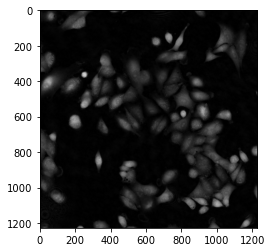

In [28]:
# results to csv

get_statistics_csv()

In [ ]:
# save to file
import os.path

output_path = r'C:\Users\sotka\Desktop\CellVoyant_Results\pre-trained model\Test_Layered'

i = 0
for layer in layered:
    cv2.imwrite(os.path.join(output_path, short_names[i]+'_layered.tif'), layer)
    i += 1